In [153]:
# To begin using librosa we need to import it, and other tools such as matplotlib and numpy
from __future__ import print_function # use the print() function from Python3
from operator import add
from pylab import *
import librosa             # The librosa library
import librosa.display     # librosa's display module (for plotting features)
import IPython.display     # IPython's display module (for in-line audio)
import matplotlib.pyplot as plt # matplotlib plotting functions
import matplotlib.style as ms   # plotting style
import numpy as np              # numpy numerical functions
ms.use('seaborn-muted')         # fancy plot designs
import soundfile as sf
from numpy import random
from scipy import signal
from statistics import mean 
import scipy.io.wavfile as wavf
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
from sklearn.decomposition import PCA

## Importing custom library for tree mutation and generation...
Starter code for this library was written by Ratan Dey

In [154]:
from tree_lib import * 

#### Important Functions:

- makeTree(expression): creates a tree based representation of any expression
- prettyParse(tree): parses any expression tree into the original expression (inorder traversal)
- COO(tree): Change of Operator
- COV(tree): Change of Operand
- CEXT(tree): Extend
- TRM(tree): Trim
- mutate(tree, TRM_flag = 0): randomly mutates the tree using Change of Operator, Change of Operand, Extension, or Trim (won't trim if TRM_flag is set to zero)
- cross(tree1, tree2, max_height = None): crossover two trees (you can limit the height at which crossover is performed)
- stuborn_mutate(tree, TRM_flag = 0): mutate until child is valid for a rendering between 0 -> 2000
- render(trees, fs, seconds): Render a list of expressions for a certain time duration at fs frequency. Returns renderings and dead expressions if there are any.
- extract_features(tree): extracts tree-related features
- randomTree(): returns a random tree starting with 3 random nodes and performing a random amount of extensions.
- create(): returns a random tree valid for rendering between 0 --> 2000
- stuborn_create(): mutate until creation has meets spectral criteria

In [155]:
df = pd.read_csv("all_features.csv")
df = df.drop(columns=['Unnamed: 0'])

Loading DB of 1000 rated expressions with features extracted...

In [156]:
df.columns

Index(['expression', 'rating', 'tempo', 'avg_cent', 'std_cent', 'avg_rolloff',
       'std_rolloff', 'avg_zcross', 'std_zcross', 'avg_flt', 'std_flt',
       'avg_bw', 'avg_ctr', 'std_ctr', 'height', 'leaves', 't-count',
       'operators', '2_powers', 'avg_operand', 'std_operand', 'r(>>)', 'r(*)',
       'r(&)', 'r(^)', 'r(%)', 'r(|)', 'r(-)', 'r(+)', 'r(/)', '>>', '*', '&',
       '^', '%', '|', '-', '+', '/'],
      dtype='object')

The current spectral and temporal features are:
- tempo: Tempo
- avg_cent: Average Spectral Centroid
- std_cent: Standard Deviation of Spectral Centroid
- avg_rolloff: Average Spectral Rolloff
- std_rolloff: Standard Deviation of Spectral Rolloff
- avg_zcross: Average Zero Crossing Rate
- std_zcross: Standard Deviation of Zero Crossing Rate
- avg_flt: Average Spectral Flatness
- std_flt: Standard Deviation of Spectral Flatness
- avg_bw: Average Spectral Bandwidth
- avg_ctr: Average Spectral Contrast
- std_ctr: Standard Deviation of Spectral Contrast

The current tree features I am working with are:
- depth: depth of tree
- Count of each operator
- root: operator at root node (dummy)
- operand_ct: count of non-“t” leaves
- t_ct: count of “t” leaves
- leaf_avg: average of non-“t” operands
- leaf_std: standard deviation of non-t operands

In [157]:
df

,expression,rating,tempo,avg_cent,std_cent,avg_rolloff,std_rolloff,avg_zcross,std_zcross,avg_flt,...,r(/),>>,*,&,^,%,|,-,+,/
0,(t^(t|11))^((t*12)&11),0,0.000000,2397.742187,15.091598,3499.092151,18.751655,0.623013,0.018510,0.000018,...,0,0,1,1,2,0,1,0,0,0
1,t*(t/10),5,0.000000,1967.835677,139.002189,3359.908049,107.338253,0.498658,0.056105,0.405539,...,0,0,1,0,0,0,0,0,0,1
2,(t|(t&7))*(t/8),5,0.000000,1973.796906,123.739123,3380.505397,84.243555,0.498456,0.015501,0.297074,...,0,0,1,1,0,0,1,0,0,1
3,((t>>6)-(t^((t>>1)|5)))-((t>>4)&5),10,0.000000,1090.473150,82.708608,2546.341951,161.222079,0.030035,0.003914,0.064719,...,0,3,0,1,1,0,1,2,0,0
4,(t*((3+(1^((t>>10)&5)))*(5+(3&(t>>14)))))>>((t...,80,0.000000,1375.247172,125.774728,2883.745336,125.740283,0.127081,0.045806,0.094418,...,0,4,2,3,1,0,0,0,2,0
5,t>>((t^(t|11))*(((t|8)&(((t>>10)*(t&11))*10))>...,45,58.593750,1405.434159,318.545960,2943.813300,549.612072,0.210597,0.125716,0.014998,...,0,3,3,2,1,0,2,0,0,0
6,((t>>13)>>(t&(t&(t>>15))))|(t>>(t*(t>>12))),10,14.648438,142.246772,125.576124,64.690498,310.284654,0.000122,0.000870,0.000069,...,0,5,1,2,0,0,1,0,0,0
7,(t|9)>>((t&9)*7),10,14.648438,1643.016174,79.731008,3641.749400,70.769139,0.279184,0.031679,0.000308,...,0,1,1,1,0,0,1,0,0,0
8,t*(((t>>6)&12)|(((t>>12)&25)^(((t>>10)&12)&(t>...,90,15.120968,1442.582115,280.605665,2862.548308,287.227102,0.120822,0.062164,0.054682,...,0,4,1,4,1,0,1,0,0,0
9,(((t|5)*7)>>8)^((t*6)*11),5,17.045455,2069.834397,107.679454,3613.347881,138.731292,0.513928,0.015297,0.018100,...,0,1,3,0,1,0,1,0,0,0


# Dataset Observations

Some of the code here is based Dr. Fortuny's starter code provided at http://ml.qa.shanghai.nyu.edu/.

### Distribution & Correlations

##### Distribution

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


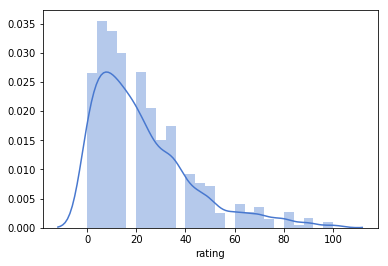

In [158]:
#plot distribution of ratings
x = df['rating']
sns.distplot(x);

As we can see, there is a high negative skew to the ratings in our dataset.

##### Tree Feature Correlations
From the correlation matrix below, we can see that the highest correlated tree features with rating are avg_operand std_operand and 2_powers. Additionally, leaves, t-count, height and opeators are highly correlated with eachother (might be good to do PCA here)


In [159]:
#Show correlations for tree features
corr = df[['rating', 'height', 'leaves', 't-count', 'operators', '2_powers', 'avg_operand', 'std_operand']].corr()
corr.style.background_gradient(cmap='coolwarm')

,rating,height,leaves,t-count,operators,2_powers,avg_operand,std_operand
rating,1,-0.0834008,0.0017987,-0.00773334,-0.00316583,-0.138505,0.176796,0.139846
height,-0.0834008,1,0.609101,0.648834,0.747291,0.246458,-0.0221096,0.0223317
leaves,0.0017987,0.609101,1,0.408539,0.86124,0.372633,-0.0471526,-0.0198414
t-count,-0.00773334,0.648834,0.408539,1,0.815704,0.184773,-0.0300053,0.0136743
operators,-0.00316583,0.747291,0.86124,0.815704,1,0.339043,-0.0465905,-0.00496129
2_powers,-0.138505,0.246458,0.372633,0.184773,0.339043,1,-0.142914,-0.0381385
avg_operand,0.176796,-0.0221096,-0.0471526,-0.0300053,-0.0465905,-0.142914,1,0.798332
std_operand,0.139846,0.0223317,-0.0198414,0.0136743,-0.00496129,-0.0381385,0.798332,1


The correlation matrix below shows the correlation between rating and a dummy variable representing the operator at the root of the tree. Notice the 13% correlation between rating and root(*).

In [160]:
#Show correlations for roots
corr = df[['rating', 'r(>>)', 'r(*)', 'r(&)', 'r(^)', 'r(%)',
       'r(|)', 'r(-)', 'r(+)', 'r(/)']].corr()
corr.style.background_gradient(cmap='coolwarm')

,rating,r(>>),r(*),r(&),r(^),r(%),r(|),r(-),r(+),r(/)
rating,1,-0.0931581,0.131567,0.0792075,-0.000157907,-0.0563614,-0.0361271,-0.0834279,-0.0408557,-0.0399691
r(>>),-0.0931581,1,-0.191806,-0.281451,-0.156496,-0.0530541,-0.165454,-0.108618,-0.0954759,-0.0432089
r(*),0.131567,-0.191806,1,-0.292067,-0.162399,-0.0550552,-0.171695,-0.112715,-0.0990771,-0.0448387
r(&),0.0792075,-0.281451,-0.292067,1,-0.2383,-0.0807866,-0.25194,-0.165395,-0.145383,-0.0657952
r(^),-0.000157907,-0.156496,-0.162399,-0.2383,1,-0.04492,-0.140087,-0.0919654,-0.0808379,-0.0365843
r(%),-0.0563614,-0.0530541,-0.0550552,-0.0807866,-0.04492,1,-0.0474912,-0.0311774,-0.027405,-0.0124025
r(|),-0.0361271,-0.165454,-0.171695,-0.25194,-0.140087,-0.0474912,1,-0.0972294,-0.085465,-0.0386784
r(-),-0.0834279,-0.108618,-0.112715,-0.165395,-0.0919654,-0.0311774,-0.0972294,1,-0.0561066,-0.0253918
r(+),-0.0408557,-0.0954759,-0.0990771,-0.145383,-0.0808379,-0.027405,-0.085465,-0.0561066,1,-0.0223195
r(/),-0.0399691,-0.0432089,-0.0448387,-0.0657952,-0.0365843,-0.0124025,-0.0386784,-0.0253918,-0.0223195,1


The correlation matrix below shows the correlations between the count of each operator and the rating. Surprisingly, the count of the multiplication operator that was highly correlated in the root dummy variable is much less correlated. The highest correlated operator in terms of count is the bitshift operator.

In [161]:
#Show correlations for operator counts
corr = df[['rating','>>', '*', '&',
       '^', '%', '|', '-', '+', '/']].corr()
corr.style.background_gradient(cmap='coolwarm')

,rating,>>,*,&,^,%,|,-,+,/
rating,1,0.112013,0.00142417,-0.0140651,-0.060383,-0.0174702,0.0785207,-0.114726,-0.0872076,-0.082877
>>,0.112013,1,0.00915075,0.111517,-0.0029787,-0.0384431,0.0378214,-0.0528314,-0.0173025,-0.117833
*,0.00142417,0.00915075,1,0.0093483,0.00682457,-0.0788404,-0.0169503,-0.0545454,-0.0337544,0.0357618
&,-0.0140651,0.111517,0.0093483,1,-0.000534947,-0.0855214,-0.108128,-0.0294226,-0.0408373,-0.146021
^,-0.060383,-0.0029787,0.00682457,-0.000534947,1,0.00352656,-0.0306048,0.0820985,0.0399799,-0.0288003
%,-0.0174702,-0.0384431,-0.0788404,-0.0855214,0.00352656,1,0.098417,-0.0161447,0.00389687,0.043561
|,0.0785207,0.0378214,-0.0169503,-0.108128,-0.0306048,0.098417,1,-0.00267218,0.0158496,0.0180516
-,-0.114726,-0.0528314,-0.0545454,-0.0294226,0.0820985,-0.0161447,-0.00267218,1,-0.0107844,0.100942
+,-0.0872076,-0.0173025,-0.0337544,-0.0408373,0.0399799,0.00389687,0.0158496,-0.0107844,1,0.081971
/,-0.082877,-0.117833,0.0357618,-0.146021,-0.0288003,0.043561,0.0180516,0.100942,0.081971,1


##### Spectral Feature Correlations
The correlation matrix below shows the relationship between spectral features and ratings. Here we start to see some higher correlations. Standard deviation of spectral centroid (std_cent) has a correlation with rating of 33%, which is likely because it measures variations in pitch. Flat tones would be rated lower and have a lower std_cent which makes sense. The same logic holds for standard deviation of zero crossing rate which is a similar measure.

In [162]:
#Show correlations for spectral and temporal features
audio_corr_df = df[['rating','tempo', 'avg_cent', 'std_cent', 'avg_rolloff',
       'std_rolloff', 'avg_zcross', 'std_zcross', 'avg_flt', 'std_flt',
       'avg_bw', 'avg_ctr', 'std_ctr']].corr()
audio_corr_df.style.background_gradient(cmap='coolwarm')

,rating,tempo,avg_cent,std_cent,avg_rolloff,std_rolloff,avg_zcross,std_zcross,avg_flt,std_flt,avg_bw,avg_ctr,std_ctr
rating,1,0.0443342,0.0237432,0.329114,-0.00350456,0.25134,0.00768306,0.233309,-0.0199588,0.11371,-0.0749968,0.0243476,0.0252496
tempo,0.0443342,1,-0.155278,0.0321973,-0.126201,0.129109,-0.136931,-0.101642,-0.0734461,-0.0638925,-0.0396133,-0.0202701,-0.0293409
avg_cent,0.0237432,-0.155278,1,0.101766,0.933699,-0.347633,0.876147,0.498722,0.422792,0.370121,0.691742,-0.000562852,-0.0761317
std_cent,0.329114,0.0321973,0.101766,1,0.0708943,0.758175,0.164043,0.721714,-0.0165424,0.0878873,0.0256335,0.079022,0.201484
avg_rolloff,-0.00350456,-0.126201,0.933699,0.0708943,1,-0.338654,0.729798,0.413392,0.333685,0.314136,0.863467,0.00840067,-0.09137
std_rolloff,0.25134,0.129109,-0.347633,0.758175,-0.338654,1,-0.206501,0.274419,-0.219548,-0.1245,-0.260109,0.112716,0.236548
avg_zcross,0.00768306,-0.136931,0.876147,0.164043,0.729798,-0.206501,1,0.570685,0.384998,0.286552,0.477345,-0.0020923,-0.0150187
std_zcross,0.233309,-0.101642,0.498722,0.721714,0.413392,0.274419,0.570685,1,0.219221,0.285836,0.255505,0.00488507,0.0429826
avg_flt,-0.0199588,-0.0734461,0.422792,-0.0165424,0.333685,-0.219548,0.384998,0.219221,1,0.735457,0.1217,-0.316024,-0.296665
std_flt,0.11371,-0.0638925,0.370121,0.0878873,0.314136,-0.1245,0.286552,0.285836,0.735457,1,0.144412,-0.202864,-0.15295


### Clustering

In [163]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

Here we analyze our data using k-means clustering on three different types of features: High Level Tree Features, Low Level Tree Features, and Key Spectral Features. We use the "elbow" method to select the optimal number of clusters. These clusters provide several insights described in our final paper.

##### High Level Tree Features

In [164]:
#Select high level tree features
HLtree_clustering_df = df[['height', 'leaves', 't-count', 'operators', '2_powers']]

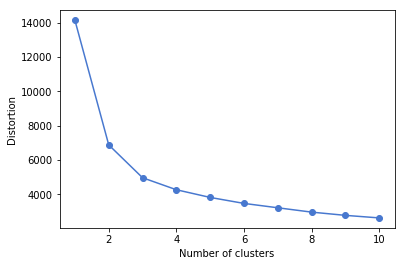

In [165]:

distortions = []
#We omit PCA in this case, but the code is useful to be copied in other scenrios

#pca = PCA(n_components=5).fit(HLtree_clustering_df)
pca_5d = HLtree_clustering_df #pca.transform(HLtree_clustering_df)


#Check best number of clusters (1 - 11)
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(pca_5d)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()   

In [166]:
# Run KMeans using "elbow" method
km = KMeans(
        n_clusters=3, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0)

km.fit(pca_5d)

pca = PCA(n_components=2).fit(HLtree_clustering_df)
pca_2d = pca.transform(HLtree_clustering_df)

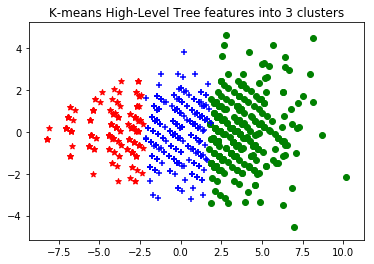

In [167]:
for i in range(0, pca_2d.shape[0]):
    if km.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',
        marker='+')
    elif km.labels_[i] == 1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='g',
        marker='o')
    elif km.labels_[i] == 2:
        c3 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',
        marker='*')
    elif km.labels_[i] == 3:
        c3 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='m',
        marker='*')
    #pl.legend([c1, c2, c3],['Cluster 1', 'Cluster 2',
        #'Clus ter 3])
        
#Plot clusters
plt.title('K-means High-Level Tree features into 3 clusters')
plt.show()

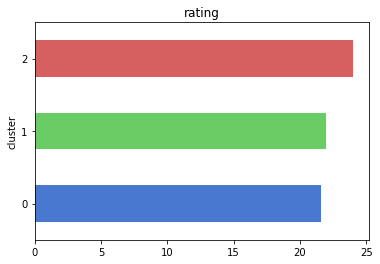

In [168]:
# Plot clusters by ratings
df["cluster"] = km.labels_
ax = df.groupby(['cluster'])['rating'].mean().plot.barh(title = "rating", y = "rating")

In [169]:
#Show cluster features
centers = pd.DataFrame(km.cluster_centers_, columns = ['height', 'leaves', 't-count', 'operators', '2_powers'])
centers

,height,leaves,t-count,operators,2_powers
0,4.922892,4.619277,4.469880,8.089157,1.132530
1,5.853583,6.249221,5.825545,11.074766,1.735202
2,3.606061,2.890152,3.015152,4.905303,0.776515


##### Low Level Tree Features

In [170]:
LLtree_clustering_df = df[['>>', '*', '&', '^', '%', '|', '-', '+', '/', '2_powers']]

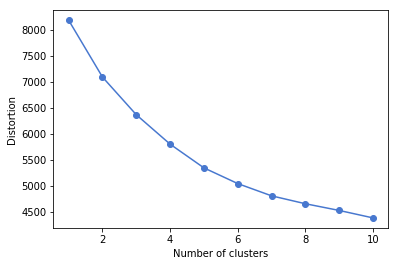

In [171]:
#Again no pca, this code was here for testing

distortions = []
#pca = PCA(n_components=3).fit(LLtree_clustering_df)
pca_3d = LLtree_clustering_df#pca.transform(LLtree_clustering_df)
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(pca_3d)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()   


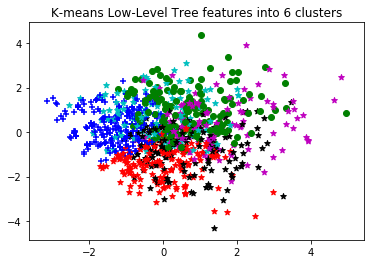

In [172]:
#Hard to find elbow here, but we used six

km = KMeans(
        n_clusters=6, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0)

km.fit(pca_3d)

pca = PCA(n_components=2).fit(LLtree_clustering_df)
pca_2d = pca.transform(LLtree_clustering_df)

for i in range(0, pca_2d.shape[0]):
    if km.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',
        marker='+')
    elif km.labels_[i] == 1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='g',
        marker='o')
    elif km.labels_[i] == 2:
        c3 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',
        marker='*')
    elif km.labels_[i] == 3:
        c3 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='m',
        marker='*')
    
    elif km.labels_[i] == 4:
        c3 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='c',
        marker='*')
        
    elif km.labels_[i] == 5:
        c3 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='k',
        marker='*')
        
    #pl.legend([c1, c2, c3],['Cluster 1', 'Cluster 2',
        #'Clus ter 3])

#plot clusters
plt.title('K-means Low-Level Tree features into 6 clusters')
plt.show()

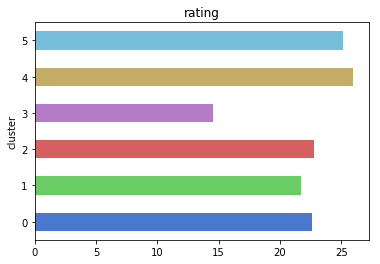

In [173]:
# Plot clusters by ratings
df["cluster"] = km.labels_
ax = df.groupby(['cluster'])['rating'].mean().plot.barh(title = "rating", y = "rating")

In [174]:
#Show cluster features
centers = pd.DataFrame(km.cluster_centers_, columns = ['>>', '*', '&', '^', '%', '|', '-', '+', '/', '2_powers'])
centers

,>>,*,&,^,%,|,-,+,/,2_powers
0,1.390071,0.921986,1.184397,0.627660,0.297872,0.453901,0.262411,0.269504,0.056738,0.666667
1,1.813665,3.322981,1.739130,0.919255,0.236025,0.708075,0.285714,0.273292,0.068323,1.316770
2,1.854651,1.145349,3.494186,0.802326,0.238372,0.668605,0.313953,0.238372,0.017442,0.790698
3,2.206897,1.344828,2.155172,1.620690,0.482759,0.956897,0.560345,0.534483,0.017241,3.232759
4,2.026087,1.173913,1.286957,0.834783,0.495652,2.695652,0.304348,0.339130,0.060870,1.226087
5,3.915584,1.292208,1.909091,0.694805,0.246753,0.746753,0.253247,0.279221,0.032468,1.168831


##### Key Spectral Features

In [175]:
# Select only highly correlated spectral and temporal features
audio_clustering_df = df[['std_cent', 'std_rolloff', 'std_zcross', 'std_flt', 'tempo']]

In [176]:
import pylab as pl

#Normalize features
scaler = preprocessing.StandardScaler()
scaler.fit_transform(audio_clustering_df)

array([[-1.4931303 , -1.24014617, -0.64507752, -0.61257103, -1.94301496],
       [-0.46385074, -0.87507816, -0.15051755,  1.9320745 , -1.94301496],
       [-0.5906354 , -0.9702521 , -0.68466037, -0.20969997, -1.94301496],
       ...,
       [-0.55863746, -0.91245177,  0.5154952 ,  1.60841578,  1.44674745],
       [-1.42159408, -1.1283884 , -0.47867818, -0.37525479,  0.17558655],
       [ 0.49082816,  0.1110821 ,  0.62986877, -0.55808239,  0.17558655]])

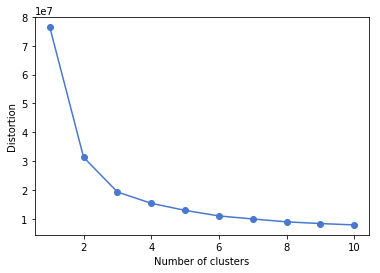

In [177]:

#This time we do PCA
distortions = []
pca = PCA(n_components=3).fit(audio_clustering_df)
pca_3d = audio_clustering_df
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(pca_3d)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()  

In [178]:
# We choose elbow as 4 even though some might argue it is 3
km = KMeans(
        n_clusters=4, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0)

In [179]:
km.fit(pca_3d)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=4,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=0,
       tol=0.0001, verbose=0)

In [180]:
pca = PCA(n_components=2).fit(audio_clustering_df)
pca_2d = pca.transform(audio_clustering_df)

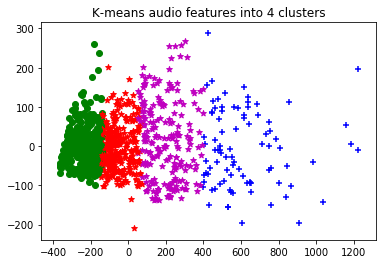

In [181]:
for i in range(0, pca_2d.shape[0]):
    if km.labels_[i] == 0:
        c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='b',
        marker='+')
    elif km.labels_[i] == 1:
        c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g',
        marker='o')
    elif km.labels_[i] == 2:
        c3 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r',
        marker='*')
    elif km.labels_[i] == 3:
        c3 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='m',
        marker='*')
    #pl.legend([c1, c2, c3],['Cluster 1', 'Cluster 2',
        #'Clus ter 3])

#Plot clusters
pl.title('K-means audio features into 4 clusters')
pl.show()

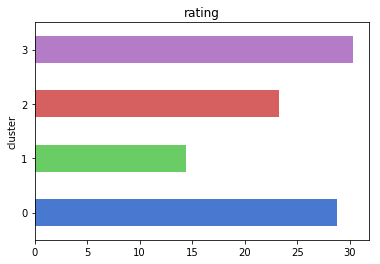

In [182]:
# Plot clusters by rating
df["cluster"] = km.labels_
ax = df.groupby(['cluster'])['rating'].mean().plot.barh(title = "rating", y = "rating")

In [183]:
#Plot cluster features
centers = pd.DataFrame(km.cluster_centers_, columns = ['std_cent', 'std_rolloff', 'std_zcross', 'std_flt', 'tempo'])
centers

,std_cent,std_rolloff,std_zcross,std_flt,tempo
0,419.448134,890.821973,0.121518,0.008364,110.902296
1,109.053597,106.028094,0.042547,0.017201,103.363785
2,163.542598,269.378684,0.053989,0.016568,95.665735
3,280.705677,489.391499,0.103257,0.013978,129.152439


### Prediction Models

Here we test four models to try to predict ratings. Some of the code here is based Dr. Fortuny's starter code provided at http://ml.qa.shanghai.nyu.edu/. 

This is only a small sample of the testing we did for these models throughout several different notebooks.

##### Support Vector Regression

In [184]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

#Limit the features, excluding dummy and operator count
X = np.array(df[[
 'tempo',
 'avg_cent',
 'std_cent',
 'avg_rolloff',
 'std_rolloff',
 'avg_zcross',
 'std_zcross',
 'avg_flt',
 'std_flt',
 'avg_bw',
 'avg_ctr',
 'std_ctr',
 'height',
 'leaves',
 't-count',
 'operators',
 '2_powers',
 'avg_operand',
 'std_operand']])
y = np.array(df[['rating']]).squeeze()

#Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)



#Normalize inputs
scaler = preprocessing.StandardScaler()
scaler.fit_transform(X_train)

scaler.transform(X_test)


# Define SVM
svr_rbf = SVR(C=1, gamma="auto", kernel = "rbf")

parameters = {'C':np.arange(.1,10,.1), 'epsilon': np.arange(0,2,.1)}


# run grid search
clf = RandomizedSearchCV(svr_rbf, param_distributions=parameters,
                            cv=5,
                            n_iter=100,
                            refit=True,
                            return_train_score=False,
                            scoring='neg_mean_squared_error',
                            random_state=1)

# fit data

clf.fit(X_train, y_train)
print(sorted(clf.cv_results_.keys()))

['mean_fit_time', 'mean_score_time', 'mean_test_score', 'param_C', 'param_epsilon', 'params', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'std_fit_time', 'std_score_time', 'std_test_score']


In [185]:
# get best params
clf.best_params_

{'epsilon': 1.7000000000000002, 'C': 9.700000000000001}

In [186]:
# run SVR with best params

svr_rbf = SVR(C=1, gamma="auto", epsilon=.2)
svr_rbf.fit(X_train, y_train)
y_pred = svr_rbf.predict(X_train)
y_pred_test = svr_rbf.predict(X_test)
SVR_train_mse = mean_squared_error(y_train, y_pred)
SVR_test_mse = mean_squared_error(y_test, y_pred_test)
print("Train MSE: %d" % SVR_train_mse)
print("Test MSE: %d" % SVR_test_mse)

Train MSE: 388
Test MSE: 342


##### SGD Regressor

In [187]:
from sklearn.linear_model import SGDRegressor

sgd_model = SGDRegressor(
    loss="squared_loss",     # the loss function to be used
    penalty="l1",            # the type of regularization component to use
    max_iter=1000,           # maximal number of epochs
    tol=1e-4,                # tolerance for the stopping condition (stops if it 
                             # can't improve the result more than tol), this speeds 
                             # up model building and is great for prototyping
    alpha = 0,               # regularization strength, low = free model, high = controlled model
    random_state=0           # random seed
)

In [188]:
# Limit input dimensions
X = np.array(df[[
 'tempo',
 'avg_cent',
 'std_cent',
 'avg_rolloff',
 'std_rolloff',
 'avg_zcross',
 'std_zcross',
 'avg_flt',
 'std_flt',
 '2_powers',
 'avg_operand',
 'std_operand']])

y = np.array(df[['rating']]).squeeze()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [189]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error


# set up SGD pipeline
pipeline = Pipeline([
    ('mm',   MinMaxScaler()),
    ('poly', PolynomialFeatures()),
    ('sgd',  SGDRegressor(penalty="l2",max_iter=1000,tol=1e-4,alpha=1e-3,random_state=0)),
])

# train pipeline
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('mm', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('poly',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('sgd',
                 SGDRegressor(alpha=0.001, average=False, early_stopping=False,
                              epsilon=0.1, eta0=0.01, fit_intercept=True,
                              l1_ratio=0.15, learning_rate='invscaling',
                              loss='squared_loss', max_iter=1000,
                              n_iter_no_change=5, penalty='l2', power_t=0.25,
                              random_state=0, shuffle=True, tol=0.0001,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False))],
         verbose=False)

In [190]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

#define grid search parameters

parameters = {
    'poly__degree': [1,2],                             
    'sgd__alpha'   : np.logspace(-5,1,7)   
                                           
}

# set-up the grid-search
grid_search = GridSearchCV(
    pipeline,                         
    parameters,                              
    scoring='neg_mean_squared_error', 
                                      
    cv=TimeSeriesSplit(n_splits=3), 
    return_train_score=True           
                                      
)

# start the gridsearch
grid_search.fit(X_train,y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('mm',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('poly',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('sgd',
                                        SGDRegressor(alpha=0.001, average=False,
                                                     early_stopping=False,
                                                     epsilon=0...
                                     

In [191]:
grid_search.best_params_

{'poly__degree': 1, 'sgd__alpha': 0.1}

In [192]:
# fit the best params

pipeline.set_params(sgd__alpha=grid_search.best_params_['sgd__alpha'], poly__degree=grid_search.best_params_['poly__degree'])
pipeline.fit(X_train,y_train)
Y_hat = pipeline.predict(X_test)

# report the means_squared error on the test and training sets
pred = pipeline.predict(X_test)
SGD_test_mse  = mean_squared_error(pred, y_test)
pred = pipeline.predict(X_train)
SGD_train_mse  = mean_squared_error(pred, y_train)
print("Train MSE %.2f" % SGD_train_mse)
print("Test MSE %.2f" % SGD_test_mse)

Train MSE 370.13
Test MSE 311.41


##### Neural Network

In [193]:
df = pd.read_csv("all_features.csv")
df = df.drop(columns=['Unnamed: 0'])

In [194]:
# Select specific features

X = df[['tempo',
 'avg_cent',
 'std_cent',
 'avg_rolloff',
 'std_rolloff',
 'avg_zcross',
 'std_zcross',
 'avg_flt',
 'std_flt',
 'avg_bw',
 'avg_ctr',
 'std_ctr',
 'height',
 'leaves',
 't-count',
 'operators',
 '2_powers',
 'avg_operand',
 'std_operand']]

y = df[['rating']]

In [195]:
import torch

dtype = torch.float
device = torch.device("cpu")


# define train and test sizes

train_size = 800
test_size = N - train_size

#convert to tensors

x = torch.from_numpy(np.array(X, dtype = 'f')).float()
y = torch.from_numpy(np.array(y, dtype = 'f')).float()


print(y.size())
print(x.size())
print(train_size)
print(test_size)


torch.Size([1000, 1])
torch.Size([1000, 19])
800
200


In [196]:
# define starting number of neurons in hidden layers -- takes a while

hidden = 1

MSE = []

for H in range(hidden, 20):
    
    # test for five times for each number of neurons
    
    N, D_in, H1, D_out = 1000, 19, H, 1 #4
    t_loss = []
    v_loss = []
    for i in range(5):
        loss_dic = {'train': [], 'validation': []}
        train_dataset, test_dataset = torch.utils.data.random_split(torch.cat((x, y), 1), [train_size, test_size])
        X_train = train_dataset.dataset[train_dataset.indices][:, :D_in]
        X_test = test_dataset.dataset[test_dataset.indices][:, :D_in]
        y_train = train_dataset.dataset[train_dataset.indices][:, D_in: D_in + D_out]
        y_test = test_dataset.dataset[test_dataset.indices][:, D_in:D_in + D_out]

        scaler = preprocessing.StandardScaler()
        X_train = torch.from_numpy(scaler.fit_transform(X_train.numpy()))
        X_test = torch.from_numpy(scaler.transform(X_test.numpy()))

        model = torch.nn.Sequential(
            torch.nn.Linear(D_in, H1, bias=False),
            torch.nn.ReLU(),
            torch.nn.Linear(H1, D_out, bias=False),
        )

        torch.nn.init.normal_(model[0].weight)
        torch.nn.init.normal_(model[2].weight)


        mse = torch.nn.MSELoss(reduction='sum')
        
        learning_rate = 1e-6
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

        loss_dic['train'] = []
        loss_dic['validation'] = []
        torch.nn.init.normal_(model[0].weight)
        torch.nn.init.normal_(model[2].weight)
        
        #Run for 10000 backwards passes
        for t in range(10000):

            y_pred = model(X_train)
            
            loss = mse(y_pred, y_train)
            #loss = l1(y_pred, y_train)
            
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            y_validation_pred = model(X_test)

            loss_validation = mse(y_validation_pred, y_test)
            #loss_validation = l1(y_validation_pred, y_test)
            
            loss_dic['train'].append(loss / train_size)
            loss_dic['validation'].append(loss_validation / test_size)

            if t == 9999:
                t_loss.append(loss.item() / train_size)
                v_loss.append(loss_validation.item() / test_size)
    v_loss = np.array(v_loss)
    t_loss = np.array(t_loss)
    MSE.append((H, t_loss.mean(), v_loss.mean()))
    
    #report MSE ~ standard deviation for each model
    print("%d neurons in hidden layer --> Train MSE: %d ~ %d, Test MSE: %d ~ %d" % (H, t_loss.mean(), np.std(t_loss), v_loss.mean(), np.std(v_loss)))

1 neurons in hidden layer --> Train MSE: 449 ~ 42, Test MSE: 777 ~ 340
2 neurons in hidden layer --> Train MSE: 309 ~ 9, Test MSE: 454 ~ 68
3 neurons in hidden layer --> Train MSE: 278 ~ 6, Test MSE: 1034 ~ 790
4 neurons in hidden layer --> Train MSE: 272 ~ 9, Test MSE: 499 ~ 219
5 neurons in hidden layer --> Train MSE: 256 ~ 11, Test MSE: 590 ~ 510
6 neurons in hidden layer --> Train MSE: 234 ~ 9, Test MSE: 1329 ~ 1196
7 neurons in hidden layer --> Train MSE: 236 ~ 19, Test MSE: 827 ~ 650
8 neurons in hidden layer --> Train MSE: 221 ~ 21, Test MSE: 560 ~ 287
9 neurons in hidden layer --> Train MSE: 206 ~ 8, Test MSE: 343 ~ 26
10 neurons in hidden layer --> Train MSE: 185 ~ 10, Test MSE: 361 ~ 41
11 neurons in hidden layer --> Train MSE: 180 ~ 6, Test MSE: 652 ~ 460
12 neurons in hidden layer --> Train MSE: 178 ~ 9, Test MSE: 910 ~ 903
13 neurons in hidden layer --> Train MSE: 177 ~ 16, Test MSE: 411 ~ 173
14 neurons in hidden layer --> Train MSE: 166 ~ 6, Test MSE: 568 ~ 484
15 neuron

In [197]:
# print results for best model

best = min(MSE, key = lambda t: t[2])
NN_train_mse = best[1]
NN_test_mse = best[2]

print("train: %s", NN_train_mse)
print("test: %s", NN_test_mse)

train: %s 206.20884765625001
test: %s 343.01197265625


##### Logistic Regression

In [198]:
# pull all data
df = pd.read_csv("all_features.csv")
df = df.drop(columns=['Unnamed: 0'])


In [199]:
#discretize ratings

def classif(col):
    if col['rating'] > 40:
        return 1
    else:
        return 0

#save discrete values in new column
df['class'] = df.apply(classif, axis = 1)



In [200]:
df


,expression,rating,tempo,avg_cent,std_cent,avg_rolloff,std_rolloff,avg_zcross,std_zcross,avg_flt,...,>>,*,&,^,%,|,-,+,/,class
0,(t^(t|11))^((t*12)&11),0,0.000000,2397.742187,15.091598,3499.092151,18.751655,0.623013,0.018510,0.000018,...,0,1,1,2,0,1,0,0,0,0
1,t*(t/10),5,0.000000,1967.835677,139.002189,3359.908049,107.338253,0.498658,0.056105,0.405539,...,0,1,0,0,0,0,0,0,1,0
2,(t|(t&7))*(t/8),5,0.000000,1973.796906,123.739123,3380.505397,84.243555,0.498456,0.015501,0.297074,...,0,1,1,0,0,1,0,0,1,0
3,((t>>6)-(t^((t>>1)|5)))-((t>>4)&5),10,0.000000,1090.473150,82.708608,2546.341951,161.222079,0.030035,0.003914,0.064719,...,3,0,1,1,0,1,2,0,0,0
4,(t*((3+(1^((t>>10)&5)))*(5+(3&(t>>14)))))>>((t...,80,0.000000,1375.247172,125.774728,2883.745336,125.740283,0.127081,0.045806,0.094418,...,4,2,3,1,0,0,0,2,0,1
5,t>>((t^(t|11))*(((t|8)&(((t>>10)*(t&11))*10))>...,45,58.593750,1405.434159,318.545960,2943.813300,549.612072,0.210597,0.125716,0.014998,...,3,3,2,1,0,2,0,0,0,1
6,((t>>13)>>(t&(t&(t>>15))))|(t>>(t*(t>>12))),10,14.648438,142.246772,125.576124,64.690498,310.284654,0.000122,0.000870,0.000069,...,5,1,2,0,0,1,0,0,0,0
7,(t|9)>>((t&9)*7),10,14.648438,1643.016174,79.731008,3641.749400,70.769139,0.279184,0.031679,0.000308,...,1,1,1,0,0,1,0,0,0,0
8,t*(((t>>6)&12)|(((t>>12)&25)^(((t>>10)&12)&(t>...,90,15.120968,1442.582115,280.605665,2862.548308,287.227102,0.120822,0.062164,0.054682,...,4,1,4,1,0,1,0,0,0,1
9,(((t|5)*7)>>8)^((t*6)*11),5,17.045455,2069.834397,107.679454,3613.347881,138.731292,0.513928,0.015297,0.018100,...,1,3,0,1,0,1,0,0,0,0


In [201]:
from sklearn.model_selection import train_test_split

# limit inputs to five temporal and spectral features

X = df[['std_cent', 'std_rolloff', 'std_zcross', 'std_flt', 'tempo']]
y = df[['class']].squeeze()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [202]:
from sklearn.linear_model import LogisticRegression

#fit log regression on discretized ratings
clf = LogisticRegression(random_state=0, solver='lbfgs',
                 multi_class='multinomial').fit(X_train, y_train)

In [203]:
# printg MSE for train and test using 100*probability as output

ytrain_pred = 100*clf.predict_proba(X_train)[:][:,1]
ytest_pred = 100*clf.predict_proba(X_test)[:][:,1]
MSE = mean_squared_error(y_train, ytrain_pred)
MSE2 = mean_squared_error(y_test, ytest_pred)
print("training MSE: " + str(MSE))
print("testing MSE: " + str(MSE2))

training MSE: 256.2508066184325
testing MSE: 251.53404047492234


In [204]:
# Save best model for future use
import pickle
pickle.dump(clf, open("logistic.sav", 'wb'))

#### Model Comparison

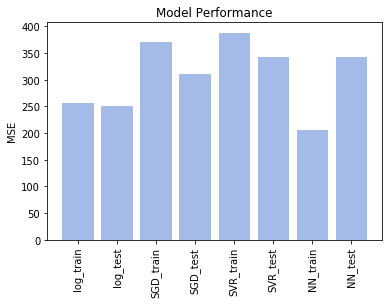

In [205]:
y_pos = ['log_train', 'log_test', 'SGD_train', 'SGD_test', 'SVR_train', 'SVR_test', 'NN_train', 'NN_test']
model_results = [MSE,MSE2,SGD_train_mse,SGD_test_mse, SVR_train_mse, SVR_test_mse, NN_train_mse, NN_test_mse]

plt.bar(y_pos, model_results, align='center', alpha=0.5)
plt.xticks(y_pos, y_pos, rotation='vertical')
plt.ylabel('MSE')
plt.title('Model Performance')
plt.show()

### Genetic Algorithm (some things take a while)

You can listen to your creations at: http://wry.me/toys/bytebeat/

In [206]:
clf = pickle.load(open("logistic.sav", 'rb'))

In [207]:
#define fitness function as log regression
def get_fitness(X):
    X = X[['std_cent', 'std_rolloff', 'std_zcross', 'std_flt', 'tempo']]
    return 100*clf.predict_proba(X)[:][:,1]

In [208]:
#define extraction for tree and sound-based features -- will be used in each epoch
def extractor(expressions):
    
    #render and normalize the wave for each expression
    fs = 8000
    seconds = 15
    render_tups = render(expressions, fs, seconds)
    renderings = render_tups[0]
    dead_children = list(render_tups[1])
    print(dead_children)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    normalized_renderings = []
    
    #remove unrenderable children and normalize renderable ones
    expressions = list(set(expressions) - set(dead_children))
    for test in renderings:
        test_arr = np.array(test)
        test_arr = np.array([test_arr])
        test_trans = scaler.fit_transform(test_arr.T)
        normalized_renderings.append(test_trans.T[0])
        
    
    expression_testing = []
    
    #use librosa to extract sound-based features
    for i in range(len(expressions)):
        y = np.array(normalized_renderings[i], dtype = 'f')
        sr = 8000
        tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

        onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
        o_env = librosa.onset.onset_strength(y, sr=sr)
        times = librosa.times_like(o_env, sr=sr)
        intervals = [times[0]]
        for x in range(1,len(times)):
            intervals.append(times[x] - times[x-1])


        z_cross = librosa.feature.zero_crossing_rate(y=y)
        avg_zcross = z_cross.mean()
        std_zcross = np.std(z_cross)

        flatness = librosa.feature.spectral_flatness(y=y)
        avg_flt = flatness.mean()
        std_flt = np.std(flatness)

        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        avg_bw = spec_bw.mean()

        spec_ctr = librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=4)
        avg_ctr = spec_ctr.mean()
        std_ctr = np.std(spec_ctr)

        cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        avg_cent = cent.mean()
        std_cent = np.std(cent)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)
        avg_rolloff = rolloff.mean()
        std_rolloff = np.std(rolloff)
        expression_testing.append([expressions[i], tempo, avg_cent, std_cent, avg_rolloff, std_rolloff, avg_zcross, std_zcross, avg_flt, std_flt, avg_bw, avg_ctr, std_ctr])
    
    #save extracted sound features
    df = pd.DataFrame(expression_testing, columns = ['expression','tempo', 'avg_cent', 'std_cent', 'avg_rolloff', 'std_rolloff', 'avg_zcross', 'std_zcross', 'avg_flt', 'std_flt', 'avg_bw', 'avg_ctr', 'std_ctr'])
    tree_ft_array = []
    
    #extract tree features with custom library
    for expression in df['expression']:
        tree = makeTree(expression)
        features = [int(i) for i in extract_features(tree).values()]
        tree_ft_array.append(features)
        
    #join tree and sound features
    df2 = pd.DataFrame(tree_ft_array, columns = list(extract_features(tree).keys()))
    df = df.join(df2)
    X = df[['tempo',
            'avg_cent',
            'std_cent',
             'avg_rolloff',
             'std_rolloff',
             'avg_zcross',
             'std_zcross',
             'avg_flt',
             'std_flt',
             'avg_bw',
             'avg_ctr',
             'std_ctr',
             'height',
             'leaves',
             't-count',
             'operators',
             '2_powers',
             'avg_operand',
             'std_operand']]
    return df

In [209]:
# define selection method -- currently too simple
def drop_weak(df):
    low_50 = len(df)//2
    smallest = df.nsmallest(low_50, 'fitness').index.values.tolist()
    df = df.drop(smallest , inplace=True)
    return df

In [210]:
# define function to mutate trees and create new generation
def make_new_gen(expressions):
    epoch_2 = []
    for child in expressions:  
        try:
            epoch_2.append(stuborn_mutate(makeTree(child)))
        except:
            print("Dead: %s" % child)
            
    print(len(epoch_2))
    return epoch_2

In [211]:
# define single iteration pipeline
def run_ga(epoch):
    print(len(epoch))
    drop_weak(epoch)
    print(len(epoch))
    children = make_new_gen(list(epoch['expression']))
    epoch2 = extractor(children)
    epoch2['fitness'] = get_fitness(epoch2)
    epoch = epoch.append(epoch2)
    return epoch

In [212]:
# define multiple iteration function
def iterate_ga(epoch, n):
    for i in range(1,n+1):
        epoch.to_csv('epochs/epoch' + str(i) + '.csv')
        epoch = run_ga(epoch)

In [213]:
# open 500 randomly generated expressions
epoch1 = []

f = open("generated_data.txt", "r")
for x in f:
  epoch1.append(x.strip('\n'))
f.close()

In [214]:
# select first 100 for testing
epoch1 = epoch1[0:100]

In [215]:
# extract features
epoch1 = extractor(epoch1)

[]


/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel 

/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel 

/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/anaconda3/lib/python3.7/site-packages/librosa/beat.py:309: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))
/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mel

/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/anaconda3/lib/python3.7/site-packages/librosa/beat.py:309: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))
/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mel

/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/anaconda3/lib/python3.7/site-packages/librosa/beat.py:309: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))
/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mel

/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/anaconda3/lib/python3.7/site-packages/librosa/beat.py:309: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))
/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mel

/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/anaconda3/lib/python3.7/site-packages/librosa/beat.py:309: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))
/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mel

/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel 

/anaconda3/lib/python3.7/site-packages/librosa/beat.py:309: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))
/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mel

/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/anaconda3/lib/python3.7/site-packages/librosa/beat.py:309: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))
/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mel

/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/anaconda3/lib/python3.7/site-packages/librosa/beat.py:309: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))
/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mel

(t>>8)*(t^((t*4)>>7))
(((t*3)>>(t*(t+5)))*(t|5))|((t&4)&6)
t&((t*(t>>7))^9)
(t*(t*6))*(((t*9)&(t^(t^8)))*9)
((((t-4)*7)>>5)>>(t&6))^(((t%5)>>4)-((t&6)&1))
((t&2)>>0)>>((t*(t|(t*1)))>>(t^1))
t&(t&7)
t-((t%((t*7)^9))^7)
(t|(((t*13)^9)&((t>>10)%11)))*(t^(t&11))
t*((((t>>12)^((t&8)^(t>>8)))|((t|12)^(t>>11)))/9)
(t>>(t>>8))|(((t>>6)*(t&5))*5)
t&((t>>7)&(t*9))
((t*10)>>10)^(((t&9)-9)*10)
(t-((t>>16)*16))&((t*(t*15))>>11)
t|(((t^((t+(t|6))>>6))>>6)|((t+3)*4))
t*(((t|(t^4))&(t>>6))^((t|5)^2))
(t*((t*7)>>9))*((t>>(t>>7))+(((t^3)*6)>>8))
(((t&11)*(((t+(t^8))*7)&(t+6)))%8)|((t*10)&11)
(t%10)+(((t&11)%10)*(t/13))
((t&7)|6)^((t>>7)&(t*(t&7)))
t&((t|6)&((t>>8)^5))
t|(((t>>10)*10)|(t*10))
(t>>5)>>((((t&9)|8)>>(t%8))*(t&((t|9)^9)))
(t^((((t^(t&6))&3)&2)&6))&((t-4)>>8)
(t>>9)|(t*(t*10))
(((t&6)+9)*8)*(t|(((t|4)^(t&4))*7))
((t>>(t&8))|4)*(((t*3)/6)*4)
(t-9)|(((t*((t>>12)^(t*8)))*10)^10)
(t&8)|(((t>>9)>>6)|(((t*7)-8)&6))
(t&(t*6))*(((t>>6)*((t&8)&(t>>7)))*7)
(t>>(t%7))|((((t>>10)&9)&10)&(t*7))
(((t|11)&(

In [216]:
# extract fitness value for each expression
epoch1['fitness'] = get_fitness(epoch1)

In [217]:
# run GA for 20 iterations
iterate_ga(epoch1, 20)

99
50
(((t*3)>>(t*(t+5)))*(t|5))|((t&4)&6)
(((t*3)>>(t*(t+5)))*(t|5))|((t&4)&6)
t&((t*(t>>7))^9)
t&((t*(t>>7))^9)
((((t-4)*7)>>5)>>(t&6))^(((t%5)>>4)-((t&6)&1))
((((t-4)*7)>>5)>>(t&6))^(((t%5)>>4)-((t&6)&1))
t-((t%((t*7)^9))^7)
t-((t%((t*7)^9))^7)
t-((t%((t*7)^9))^7)
t*((((t>>12)^((t&8)^(t>>8)))|((t|12)^(t>>11)))/9)
t*((((t>>12)^((t&8)^(t>>8)))|((t|12)^(t>>11)))/9)
t*(((t|(t^4))&(t>>6))^((t|5)^2))
t*(((t|(t^4))&(t>>6))^((t|5)^2))
((t&7)|6)^((t>>7)&(t*(t&7)))
((t&7)|6)^((t>>7)&(t*(t&7)))
(((t&6)+9)*8)*(t|(((t|4)^(t&4))*7))
(((t&6)+9)*8)*(t|(((t|4)^(t&4))*7))
(t-9)|(((t*((t>>12)^(t*8)))*10)^10)
(t-9)|(((t*((t>>12)^(t*8)))*10)^10)
(t&8)|(((t>>9)>>6)|(((t*7)-8)&6))
(t&8)|(((t>>9)>>6)|(((t*7)-8)&6))
(t&(t*6))*(((t>>6)*((t&8)&(t>>7)))*7)
(t&(t*6))*(((t>>6)*((t&8)&(t>>7)))*7)
(t&(t*6))*(((t>>6)*((t&8)&(t>>7)))*7)
(((t|11)&((t>>9)^11))*10)>>((t&((((t-11)*9)&13)>>8))&(t*12))
(((t|11)&((t>>9)^11))*10)>>((t&((((t-11)*9)&13)>>8))&(t*12))
((t*(t&7))-9)&((((t>>10)+10)|9)&11)
((t*(t&7))-9)&((((t>>10)

NameError: name 'dead_childre' is not defined